# RRAM Characterization Analysis Notebook

This notebook contains Python analyses of data collected on the 256x256 (64K) TCAM array developed at Stanford. The TCAM has 4 WLs that are addressed by a single WL addr, and 2 BLs that are addressed by a single SL addr.

## Notebook setup

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import Formatter, FixedLocator
from matplotlib.patches import Rectangle

In [2]:
# Set up PPF scale for CDF plots
class PPFScale(mscale.ScaleBase):
    name = "ppf"

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self, axis)

    def get_transform(self):
        return self.PPFTransform()

    def set_default_locators_and_formatters(self, axis):
        class VarFormatter(Formatter):
            def __call__(self, x, pos=None):
                return f"{x}"[1:]

        axis.set_major_locator(FixedLocator(np.array([0,.0001,.001,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99,.999,.9999,1])))
        axis.set_major_formatter(VarFormatter())


    def limit_range_for_scale(self, vmin, vmax, minpos):
        return max(vmin, 1e-6), min(vmax, 1-1e-6)

    class PPFTransform(mtransforms.Transform):
        input_dims = output_dims = 1

        def ___init__(self, thresh):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            return stats.norm.ppf(a)

        def inverted(self):
            return PPFScale.IPPFTransform()

    class IPPFTransform(mtransforms.Transform):
        input_dims = output_dims = 1

        def transform_non_affine(self, a):
            return stats.norm.cdf(a)

        def inverted(self):
            return PPFScale.PPFTransform()

# Register PPF scale
mscale.register_scale(PPFScale)

## Calibration

### Read voltage sweep

Here, we sweep the READ voltage across different programmed conductances and measure average current to see how "linear" the RRAM is. At all conductances tested, the I-V curves appear to be very linear. This ohmic behavior may simplify sense amplifier design and improve accuracy.

We will operate at 0.2V READ voltage during the remainder of these experiments, but this data confirms that the resistances/conductances measured will look similar at other READ voltages.

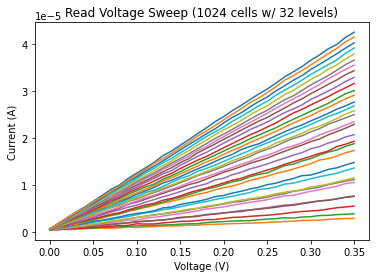

In [3]:
# Load data and get bin values
names = ["addr", "v", "i"]
data = pd.read_csv("../data/read_voltage_sweep.tsv", sep="\t", names=names)
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32

# Plot bin values
plt.title("Read Voltage Sweep (1024 cells w/ 32 levels)")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
for targbin in range(32):
    gdata = data[data["targbin"] == targbin].groupby(["v"])
    plt.plot(gdata["v"].mean(), gdata["i"].mean())
plt.show()

## FORMing

### Load log file

The log file contains all the data from the dynamic FORM process. We need to parse it and look at some statistical properties of the FORMing process.

In this dataset, FORMing is done by dynamically incrementing VWL by 50mV starting from 1.3V until the cell resistance falls below 10kOhm. The VBL is fixed at 3.3V and the pulse width is 1ms.

In [4]:
# Load log file
names = ["chip", "time", "addr", "operation", "data0", "data1", "data2", "data3"]
data = pd.read_csv("../data/form_log.csv", names=names)

# Get data from last FORM pulse and final resistance measurement only
read_data = data[data["operation"] == "READ"].groupby("addr").nth(-1)
form_data = data[data["operation"] == "SET"].groupby("addr").nth(-1)

# For SET operations: (data0, data1, data2, data3) = (VWL, VBL, VSL, PW)
# For READ operations: (data0, data1, data2, data3) = (res, g, meas_i, meas_v)
# res = resistance, g = conductance

data

chip          time   addr operation         data0     data1     data2  \
0        C5  1.619086e+09      0       SET      1.300000  3.300000  0.000000   
1        C5  1.619086e+09      0      READ   9568.829739  0.000105  0.000020   
2        C5  1.619086e+09      1       SET      1.300000  3.300000  0.000000   
3        C5  1.619086e+09      1      READ  10340.073506  0.000097  0.000018   
4        C5  1.619086e+09      1       SET      1.350000  3.300000  0.000000   
...     ...           ...    ...       ...           ...       ...       ...   
489283   C5  1.619100e+09  47531      READ   9184.311201  0.000109  0.000021   
489284   C5  1.619100e+09  48507       SET      1.300000  3.300000  0.000000   
489285   C5  1.619100e+09  48507      READ   9445.186746  0.000106  0.000020   
489286   C5  1.619100e+09  49803       SET      1.300000  3.300000  0.000000   
489287   C5  1.619100e+09  49803      READ   9957.051495  0.000100  0.000019   

           data3  
0       0.001000  
1       0.011058  
2       0.001000  
3       0.010275  
4       0.001000  
...          ...  
489283  0.011494  
489284  0.001000  
489285  0.011194  
489286  0.001000  
489287  0.010649  

[489288 rows x 8 columns]

### FORMing VWL Distribution

As shown by the distribution, most cells FORM with a single pulse as indicated by the large bar at 1.3V (first pulse). The rest of the cells appear to FORM with exponentially decaying probability.

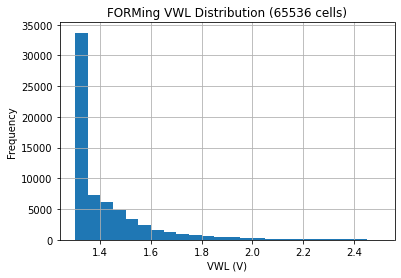

In [5]:
# VWL Distribution
form_data["data0"].hist(bins=np.arange(1.3, 2.51, 0.05001))
plt.title("FORMing VWL Distribution (65536 cells)")
plt.xlabel("VWL (V)")
plt.ylabel("Frequency")
plt.show()

### FORMing Conductance Distribution

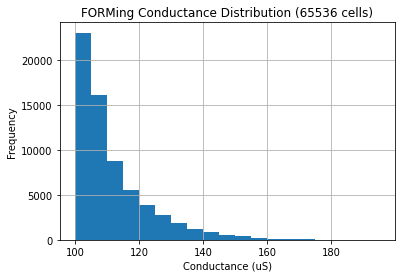

In [6]:
# Conductance Distribution
(read_data["data1"] * 1e6).hist(bins=np.arange(100, 200, 5))
plt.title("FORMing Conductance Distribution (65536 cells)")
plt.xlabel("Conductance (uS)")
plt.ylabel("Frequency")
plt.show()

### FORMing VWL Spatial Distribution

There seems to be a pattern in the FORMing voltages; every 16 rows seems to switch between lower FORMing voltages and higher FORMing voltages. It is still unclear why this is happening.


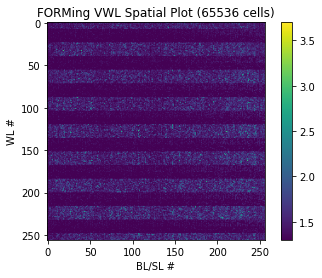

In [7]:
# FORMing VWL
mat = plt.imshow(form_data["data0"].values.reshape(256,256), interpolation=None)
plt.colorbar(mat)
plt.title("FORMing VWL Spatial Plot (65536 cells)")
plt.xlabel("BL/SL #")
plt.ylabel("WL #")
plt.show()

### FORMing Conductance Distribution

From the FORMing conductance distribution, we can infer that it is more difficult to bring the darker stripes of cells below 10kOhm, so the VWL is higher for those cells accordingly.

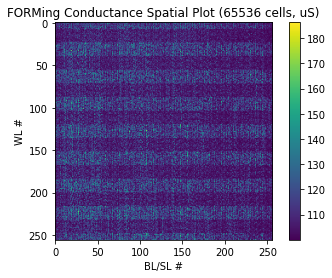

In [8]:
# FORMing Conductance
mat = plt.imshow(read_data["data1"].values.reshape(256,256) * 1e6, interpolation=None)
plt.colorbar(mat)
plt.title("FORMing Conductance Spatial Plot (65536 cells, uS)")
plt.xlabel("BL/SL #")
plt.ylabel("WL #")
plt.show()

## Multi-Bit Capability Evaluation

The first multi-bit test examines the post-programmed readout of 32 levels induced across the first 1024 cells of the array (32 cells/level * 32 levels). The programming method is DD-ISPP (dual-direction incremental step pulse programming), where the word line voltage is incremented until the cells fall into the target range. The main finding was that only the first bit line of the TCAM supports good multi-bit programming while the second bit line has huge relaxation problems. This may have something to do with the TCAM peripherals causing write disturbance. The data that led to this conclusion is presented below. All measurements are taken 15-30 minutes after programming. More information on the time-dependence of the distributions is given in the [Retention](#retention) section.

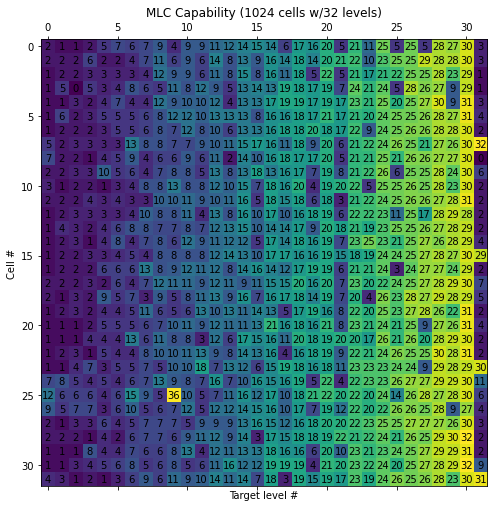

In [9]:
# Load data
names = ["addr", "r"]
data = pd.read_csv("../data/read_mlc_bad.tsv", sep="\t", names=names)
data["g"] = 1/data["r"]

# Show multi-bit result
plt.rcParams["figure.figsize"] = (8,8)
data["bin"] = np.floor(data["g"] / 4e-6)
data["targbin"] = (data["addr"] - data["addr"][0]) % 32
matdata = data["bin"].values.reshape(32,32)
plt.matshow(matdata, vmin=0, vmax=32)
plt.title("MLC Capability (1024 cells w/32 levels)")
plt.xlabel("Target level #")
plt.ylabel("Cell #")
for i in range(len(matdata)):
    for j in range(len(matdata[0])):
        c = int(matdata[j,i])
        plt.text(i, j, str(c), va="center", ha="center")
plt.show()

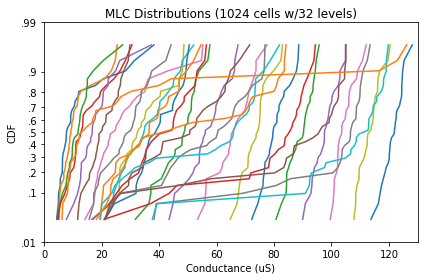

In [10]:
# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (1024 cells w/32 levels)")
for i in range(32):
    rdata = data[data["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 130)
plt.ylim(0.01, 0.99)
plt.tight_layout()
plt.show()

Note that every second cell (corresponding to the second bitline) above looks like it has deviated significantly from its programmed value. Next, we examine only cells on the first bitline to remove these outliers.

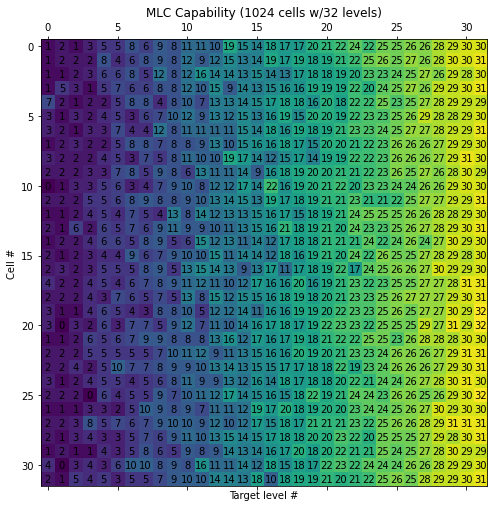

In [27]:
# Load data
names = ["addr", "r"]
data = pd.read_csv("../data/read_mlc_good.tsv", sep="\t", names=names)
data["g"] = 1/data["r"]

# Show multi-bit result
plt.rcParams["figure.figsize"] = (8,8)
data["bin"] = np.floor(data["g"] / 4e-6)
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32
matdata = data["bin"].values.reshape(32,32)
plt.matshow(matdata, vmin=0, vmax=32)
plt.title("MLC Capability (1024 cells w/32 levels)")
plt.xlabel("Target level #")
plt.ylabel("Cell #")
for i in range(len(matdata)):
    for j in range(len(matdata[0])):
        c = int(matdata[j,i])
        plt.text(i, j, str(c), va="center", ha="center")
plt.show()

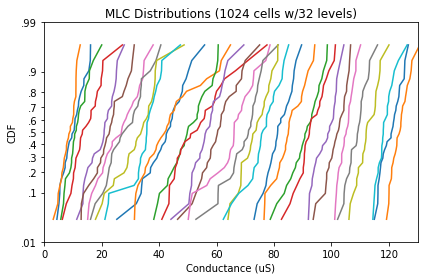

In [12]:
# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (1024 cells w/32 levels)")
for i in range(32):
    rdata = data[data["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 130)
plt.ylim(0.01, 0.99)
plt.tight_layout()
plt.show()

Now, we can try to pick out non-overlapping levels and examine them more carefully. We can get 5 non-overlapping levels here.

In [13]:
# Define the non-overlapping levels
levels = [31, 26, 21, 12, 1]

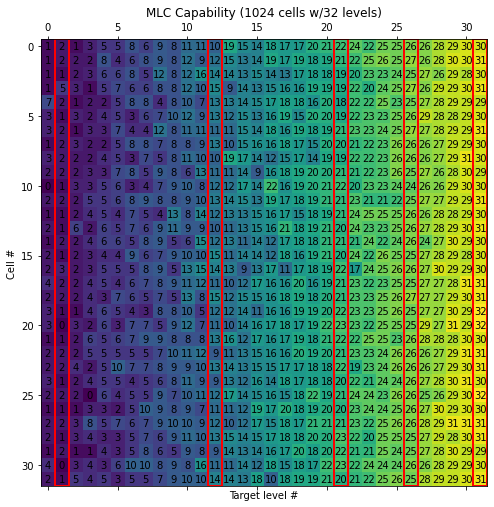

In [14]:
# Show multi-bit result
plt.rcParams["figure.figsize"] = (8,8)
data["bin"] = np.floor(data["g"] / 4e-6)
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32
matdata = data["bin"].values.reshape(32,32)
plt.matshow(matdata, vmin=0, vmax=32)
plt.title("MLC Capability (1024 cells w/32 levels)")
plt.xlabel("Target level #")
plt.ylabel("Cell #")
for i in range(len(matdata)):
    for j in range(len(matdata[0])):
        c = int(matdata[j,i])
        plt.text(i, j, str(c), va="center", ha="center")
for level in levels:
    rect = Rectangle((level - 0.5, -0.5), 1, 32, linewidth=2, edgecolor="r", facecolor="none")
    plt.gca().add_patch(rect)
plt.show()

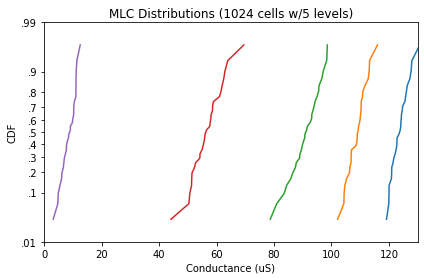

In [28]:
# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (1024 cells w/5 levels)")
for i in levels:
    rdata = data[data["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 130)
plt.ylim(0.01, 0.99)
plt.tight_layout()
plt.show()

Let's examine the distributions with more data now (16378 cells):

In [16]:
# Load data
names = ["addr", "time", "r", "g"]
data = pd.read_csv("../data/retention-many.tsv", names=names, sep="\t")
data["time"] = data["time"] - data.groupby("addr")["time"].transform("first")
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32

data

addr          time              r         g  targbin
0            0      0.000000    8984.367718  0.000111      0.0
1            2      0.000000  149959.884148  0.000007      1.0
2            4      0.000000  183820.407835  0.000005      2.0
3            6      0.000000  190713.034545  0.000005      3.0
4            8      0.000000   59833.865834  0.000017      4.0
...        ...           ...            ...       ...      ...
3562179  13702  15578.781133   59588.511960  0.000017      3.0
3562180  13704  15578.780234   78803.267971  0.000013      4.0
3562181  13706  15578.781469   39429.608924  0.000025      5.0
3562182  13708  15578.782168   33700.227612  0.000030      6.0
3562183  13710  15578.782942   46932.410196  0.000021      7.0

[3562184 rows x 5 columns]

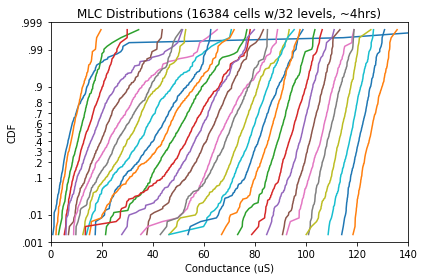

In [17]:
# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (16384 cells w/32 levels, ~4hrs)")
tdata = data.groupby("addr").nth(-1)
for i in range(32):
    rdata = tdata[tdata["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 140)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()

If we filter down to 5 levels:

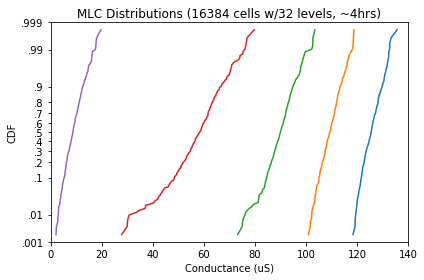

In [18]:
# Define the non-overlapping levels
levels = [31, 27, 22, 14, 1]

# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (16384 cells w/5 levels, ~4hrs)")
tdata = data.groupby("addr").nth(-1)
for i in levels:
    rdata = tdata[tdata["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 140)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()

## Retention and Read Noise
<a id="retention"></a>
In this section, we evaluate how well the cells can maintain their conductance values after programming. We first program 1024 cells (using the first bitline). After each cell is programmed, we immediately measure the short-term relaxation by performing 1000 READs. After all cells are programmed, we measure the long-term relaxation by continuously reading all cells.

### Room-Temperature Retention/Read Noise

In [19]:
# Open read file
names = ["addr", "time", "r", "g"]
data = pd.read_csv("../data/retention.tsv", names=names, sep="\t")
data["time"] = data["time"] - data.groupby("addr")["time"].transform("first")
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32
data

addr          time              r         g  targbin
0           0      0.000000  104506.555016  0.000010      0.0
1           0      0.004000   89717.187950  0.000011      0.0
2           0      0.007996  105905.073584  0.000009      0.0
3           0      0.011993  113477.254385  0.000009      0.0
4           0      0.015990  126629.661971  0.000008      0.0
...       ...           ...            ...       ...      ...
5849319   462  24257.955601   22572.876611  0.000044      7.0
5849320   464  24254.084537   20166.780035  0.000050      8.0
5849321   466  24250.099089   35920.176541  0.000028      9.0
5849322   468  24246.142325   22084.324331  0.000045     10.0
5849323   470  24242.198276   22992.548301  0.000043     11.0

[5849324 rows x 5 columns]

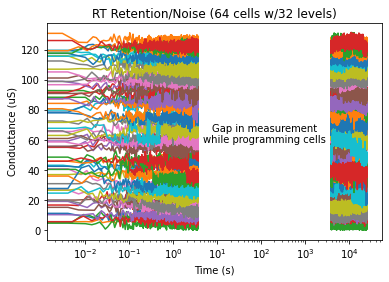

In [20]:
# Plot measured conductance vs. time
plt.title("RT Retention/Noise (64 cells w/32 levels)")
plt.xlabel("Time (s)")
plt.ylabel("Conductance (uS)")
for addr in range(0, 128, 2):
    adata = data[data["addr"] == addr]
    plt.plot(adata["time"], adata["g"]*1e6)
plt.xscale("log")
rect = Rectangle((3.8, 0), 3600, 128, edgecolor=None, facecolor="white", zorder=10)
plt.gca().add_patch(rect)
plt.text(116.96, 64, "Gap in measurement\nwhile programming cells", zorder=20, ha="center", va="center")
plt.show()

Let's look at the 5 levels we were considering before.

#### Example 1:

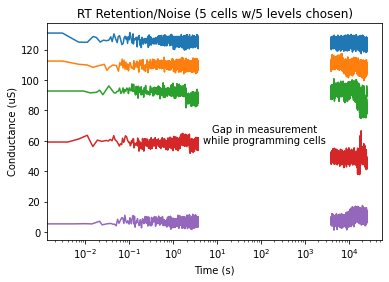

In [21]:
# Plot measured conductance vs. time
plt.title("RT Retention/Noise (5 cells w/5 levels chosen)")
plt.xlabel("Time (s)")
plt.ylabel("Conductance (uS)")
for addr in np.array(levels)*2:
    adata = data[data["addr"] == addr]
    plt.plot(adata["time"], adata["g"]*1e6)
plt.xscale("log")
rect = Rectangle((3.8, 0), 3600, 128, edgecolor=None, facecolor="white", zorder=10)
plt.gca().add_patch(rect)
plt.text(116.96, 64, "Gap in measurement\nwhile programming cells", zorder=20, ha="center", va="center")
plt.show()

#### Example 2:

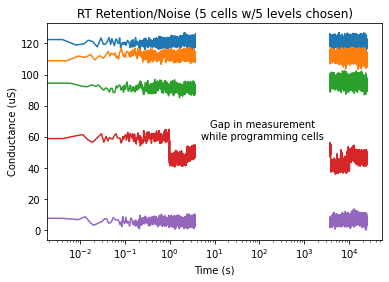

In [22]:
# Plot measured conductance vs. time
plt.title("RT Retention/Noise (5 cells w/5 levels chosen)")
plt.xlabel("Time (s)")
plt.ylabel("Conductance (uS)")
for addr in np.array(levels)*2 + 128:
    adata = data[data["addr"] == addr]
    plt.plot(adata["time"], adata["g"]*1e6)
plt.xscale("log")
rect = Rectangle((3.8, 0), 3600, 128, edgecolor=None, facecolor="white", zorder=10)
plt.gca().add_patch(rect)
plt.text(116.96, 64, "Gap in measurement\nwhile programming cells", zorder=20, ha="center", va="center")
plt.show()

#### Example 3:

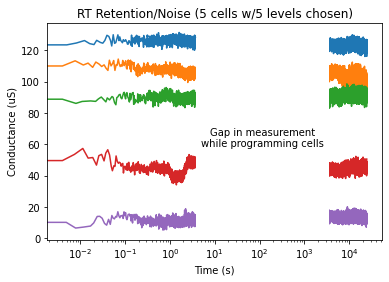

In [23]:
# Plot measured conductance vs. time
plt.title("RT Retention/Noise (5 cells w/5 levels chosen)")
plt.xlabel("Time (s)")
plt.ylabel("Conductance (uS)")
for addr in np.array(levels)*2 + 256:
    adata = data[data["addr"] == addr]
    plt.plot(adata["time"], adata["g"]*1e6)
plt.xscale("log")
rect = Rectangle((3.8, 0), 3600, 128, edgecolor=None, facecolor="white", zorder=10)
plt.gca().add_patch(rect)
plt.text(116.96, 64, "Gap in measurement\nwhile programming cells", zorder=20, ha="center", va="center")
plt.show()

The conclusion is that READ noise and drift may become an issue when you place levels too close together. If we remove the second (orange) level, we have 2 bits per cell and the READ noise does not appear to pose an issue after 7 hours. 

### Room-Temperature READ Distribution after ~7hrs

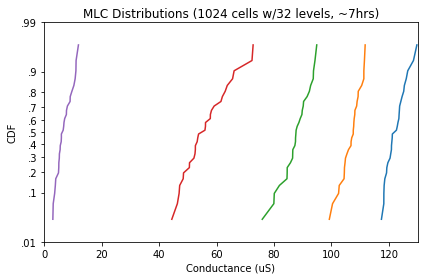

In [24]:
# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (1024 cells w/32 levels, ~7hrs)")
tdata = data.groupby("addr").nth(-1)
for i in levels:
    rdata = tdata[tdata["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 130)
plt.ylim(0.01, 0.99)
plt.tight_layout()
plt.show()

### Conductance Deviation vs. Initial Conductance

A good way to understand the stability of each conductance level is to look at the *conductance deviation plot* shown below. Intermediate conductances are less stable.

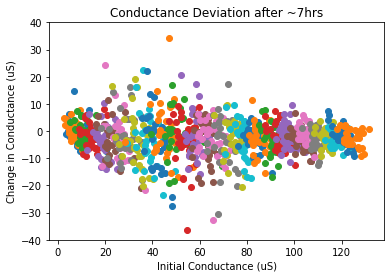

In [25]:
# Get first and last conductance values
firstdata = data.groupby("addr").nth(0)
lastdata = data.groupby("addr").nth(-1)
plt.title("Conductance Deviation after ~7hrs")
plt.xlabel("Initial Conductance (uS)")
plt.ylabel("Change in Conductance (uS)")
for i in range(32):
    fdata = firstdata[firstdata["targbin"] == i]["g"]*1e6
    ldata = lastdata[lastdata["targbin"] == i]["g"]*1e6
    deldata = ldata - fdata
    plt.plot(fdata, deldata, 'o')
    plt.ylim(-40, 40)

### High-Temperature Retention

**TODO:** 85C, 110C, 130C, 160C for 1hr

## Endurance

**TODO**

## Programming Methods and Tuning

**TODO**

## Sweeps

**TODO**

## READ Energy Tradeoffs
**TODO**